# Homework 2 : Data from the Web

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import requests
from bs4 import BeautifulSoup

# 1. Top University Ranking : QS
Next we Are going to load the data from the URL of QS. The main URL of the ranking page is the following : 

In [2]:
QS_base_URL = "https://www.topuniversities.com"
QS_data_URL = "https://www.topuniversities.com/sites/default/files/qs-rankings-data/357051.txt?_=1508016143198"

Nest, we make the HTTP Request and get the JSON file into a list of dictionnaries :

In [5]:
QS_R = requests.get(QS_data_URL)
QS_dict = QS_R.json()['data']
print(len(QS_dict))
print(QS_dict[0])

959
{'nid': '294850', 'url': '/universities/massachusetts-institute-technology-mit', 'title': 'Massachusetts Institute of Technology (MIT)', 'logo': '<img src="https://www.topuniversities.com/sites/default/files/massachusetts-institute-of-technology-mit_410_small_0.jpg" alt="Massachusetts Institute of Technology (MIT)  Logo">', 'core_id': '410', 'score': '100', 'rank_display': '1', 'country': 'United States', 'cc': 'US', 'region': 'North America', 'stars': '6', 'guide': '<a href="/where-to-study/north-america/united-states/guide" class="guide-link" target="_blank">United States</a>'}


Create an empty dataFrame for the QS Data :

In [100]:
ranking_QS = pd.DataFrame(columns = ['Name','Rank','Country','Region',\
                                     'Number of faculty members (int)','Number of faculty members (total)',\
                                     'Number of students (int)','Number of students (total)'])

print(ranking_QS.dtypes)
print(ranking_QS.head())

Name                                 object
Rank                                 object
Country                              object
Region                               object
Number of faculty members (int)      object
Number of faculty members (total)    object
Number of students (int)             object
Number of students (total)           object
dtype: object
Empty DataFrame
Columns: [Name, Rank, Country, Region, Number of faculty members (int), Number of faculty members (total), Number of students (int), Number of students (total)]
Index: []


We created the following functions. 

The first function takes a beautiful soup and extracts a specific class which it converts from string to int. 

The second function takes in input the ranking dataframe and the dictionnary of the i_th university. The aim of this function is to go look for the missing information which are in the page of the university. 

In [101]:
def get_specific_info(soup, class_):
    try: 
        info = str(soup.find('div', class_= class_).string)
        info = int(info.replace(',',''))
    except:
        info = np.nan
    return info

def get_additional_info(university_dict):
    QS_univ_URL = QS_base_URL + university_dict['url'] # this URL contains additional information that we will extract
    QS_univ_r = requests.get(QS_univ_URL)
    QS_univ_s = BeautifulSoup(QS_univ_r.text,'html.parser')
    
    ### getting info on the faculty members : 
    faculty_int_s = QS_univ_s.find('div', class_= 'total faculty')
    faculty_total_s = QS_univ_s.find('div', class_= 'inter faculty')

    faculty_members = {'In total': get_specific_info(faculty_total_s, 'number'),\
                       'International': get_specific_info(faculty_int_s, 'number')}
    
    ### getting info on the students
    student_total_s = QS_univ_s.find('div', class_= 'total student')
    student_int_s = QS_univ_s.find('div', class_= 'int-students-main')
    
    students = {'In total': get_specific_info(student_total_s, 'number') ,\
                'International': get_specific_info(student_int_s, 'number')}

    return faculty_members,students

The following code allows us to get all the information for the `n_univ` first universities, from the list of dicitonnaries `QS_dict`, and from the university website through the previous function `get_additional_info()`. All this information is set in the previous dataframe  As there are some universities that don't have the information for international faculty member, we decide to add a NaN value. 

In [102]:
n_univ = 20;
for i in range(n_univ):
    univ = QS_dict[i]
    ### Go get the missing information on the page of the univerisity
    [faculty_members,students] = get_additional_info(univ)
    
    ### create the new line of the Dataframe ranking_QS
    univ_data = [ univ['title'],univ['rank_display'].replace('=', ''),univ['country'],univ['region'],\
                      faculty_members['International'], faculty_members['In total'],\
                       students['International'], students['In total']]
    ranking_QS.loc[i] = univ_data
    

Now that we have the dataframe `ranking_QS`, we need to clean a little bit the data and convert into numbers the columns that are in strings

Note that we removed the =XXX in the `Rank` column when 2 universities have the same rank in previous cell

In [106]:
# converting the following columns to int : 
conv_2_int = ['Number of faculty members (int)','Number of faculty members (total)',\
              'Number of students (int)','Number of students (total)', 'Rank']

ranking_QS[conv_2_int] = ranking_QS[conv_2_int].apply(pd.to_numeric)

In [107]:
# display the cleaned dataframe
ranking_QS.head()

,Name,Rank,Country,Region,Number of faculty members (int),Number of faculty members (total),Number of students (int),Number of students (total)
0,Massachusetts Institute of Technology (MIT),1,United States,North America,2982,1679,3717,11067
1,Stanford University,2,United States,North America,4285,2042,3611,15878
2,Harvard University,3,United States,North America,4350,1311,5266,22429
3,California Institute of Technology (Caltech),4,United States,North America,953,350,647,2255
4,University of Cambridge,5,United Kingdom,Europe,5490,2278,6699,18770


Now we have our clean dataframe and we can compute the asked values : 

## (a)  Ratio between faculty members and students

In [246]:
ranking_QS['Ratio Faculty/Students'] = ranking_QS['Number of faculty members (total)']/ranking_QS['Number of students (total)']
ratio_fac_students = ranking_QS[['Name', 'Ratio Faculty/Students']].sort_values('Ratio Faculty/Students',ascending=False)
ratio_fac_students.set_index('Name', inplace = True)
ratio_fac_students.head(10)

,Ratio Faculty/Students
Name,
California Institute of Technology (Caltech),0.155211
Massachusetts Institute of Technology (MIT),0.151712
University of Oxford,0.150304
Yale University,0.137720
Imperial College London,0.128713
Stanford University,0.128606
Ecole Polytechnique Fédérale de Lausanne (EPFL),0.125689
University of Cambridge,0.121364
"Nanyang Technological University, Singapore (NTU)",0.116287


## (b)  Ratio of international students

In [247]:
ranking_QS['Ratio Int/Total Students'] = ranking_QS['Number of students (int)']/ranking_QS['Number of students (total)']
ratio_int_students = ranking_QS[['Name', 'Ratio Int/Total Students']].sort_values('Ratio Int/Total Students',ascending=False)
ratio_int_students.set_index('Name', inplace = True)
ratio_int_students.head(10)

,Ratio Int/Total Students
Name,
Ecole Polytechnique Fédérale de Lausanne (EPFL),0.570047
Imperial College London,0.543567
UCL (University College London),0.477928
The Australian National University,0.384365
ETH Zurich - Swiss Federal Institute of Technology,0.381681
University of Oxford,0.372870
University of Cambridge,0.356899
Massachusetts Institute of Technology (MIT),0.335863
Columbia University,0.323617


### (c) By country : average ratio of international students and  ratio between faculty members and students

We are going to display the same statistic but for each country. We only consider the Top 10 countries here.

# TODO : ask if average by country or sorting by country

In [248]:
# Top 10 : ratio of international students by country
country_rank_int_total_students = ranking_QS.groupby('Country').mean().sort_values('Ratio Int/Total Students',ascending=False)\
            [['Ratio Int/Total Students']]
country_rank_int_total_students.head(10)

#https://stackoverflow.com/questions/27842613/pandas-groupby-sort-within-groups
#ranking_QS.groupby('Country').sort_values('Ratio Int/Total Students',ascending=False)\
#            [['Ratio Int/Total Students']].head(10)

,Ratio Int/Total Students
Country,
Switzerland,0.475864
United Kingdom,0.437816
Australia,0.384365
Singapore,0.277091
United States,0.253303


In [249]:
# Top 10 : ratio between faculty members and students by country
country_rank_fac_students= ranking_QS.groupby('Country').mean().sort_values('Ratio Faculty/Students',ascending=False)\
            [['Ratio Faculty/Students']]
    
country_rank_fac_students.head(10)                                              

,Ratio Faculty/Students
Country,
United Kingdom,0.120639
Switzerland,0.110435
Singapore,0.105290
United States,0.083862
Australia,0.064188


### (d) By region : average ratio of international students and  ratio between faculty members and students

We are going to display the same statistic but for each region. As we have 6 regions, we display the whole ranking.

# TODO : ask if average by region or sorting by region

In [250]:
# Ratio of international students by region
region_int_total_students = ranking_QS.groupby('Region').mean().sort_values('Ratio Int/Total Students',ascending=False)\
            [['Ratio Int/Total Students']]
region_students.head(10)

,Ratio Int/Total Students
Region,
Europe,0.450499
Oceania,0.384365
Asia,0.277091
North America,0.253303


In [251]:
# Ratio between faculty members and students by region
region_fac_students = ranking_QS.groupby('Region').mean().sort_values('Ratio Faculty/Students',ascending=False)\
            [['Ratio Faculty/Students']]

## 1.2. Bar Plots

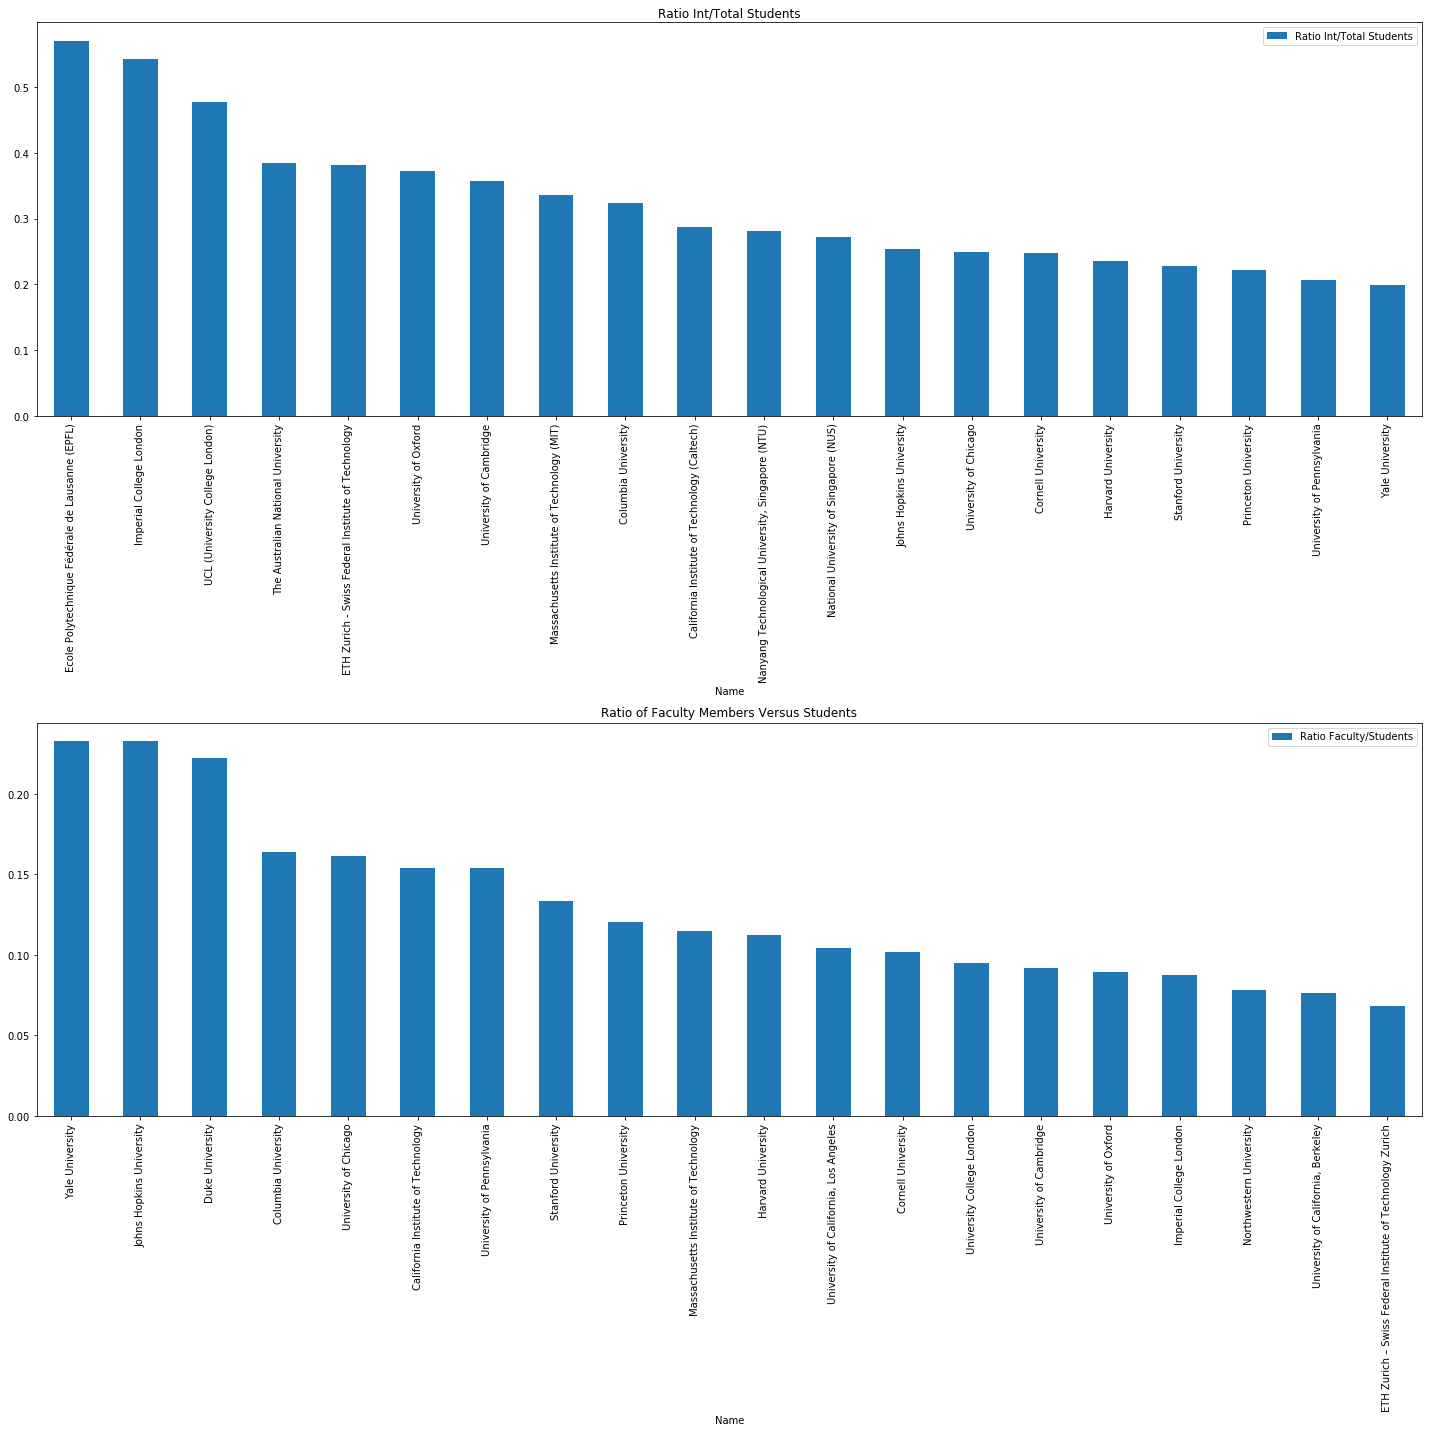

In [306]:
fig, axes = plt.subplots(nrows = 2, ncols =1, figsize  = (20,20))
ratio_int_students.plot(kind = "bar", subplots = True, ax = axes[0])
plt.title("Ratio of International Students")
ratio_fac_students.plot(kind = "bar", subplots = True, ax = axes[1])
plt.title("Ratio of Faculty Members Versus Students")
fig.tight_layout()

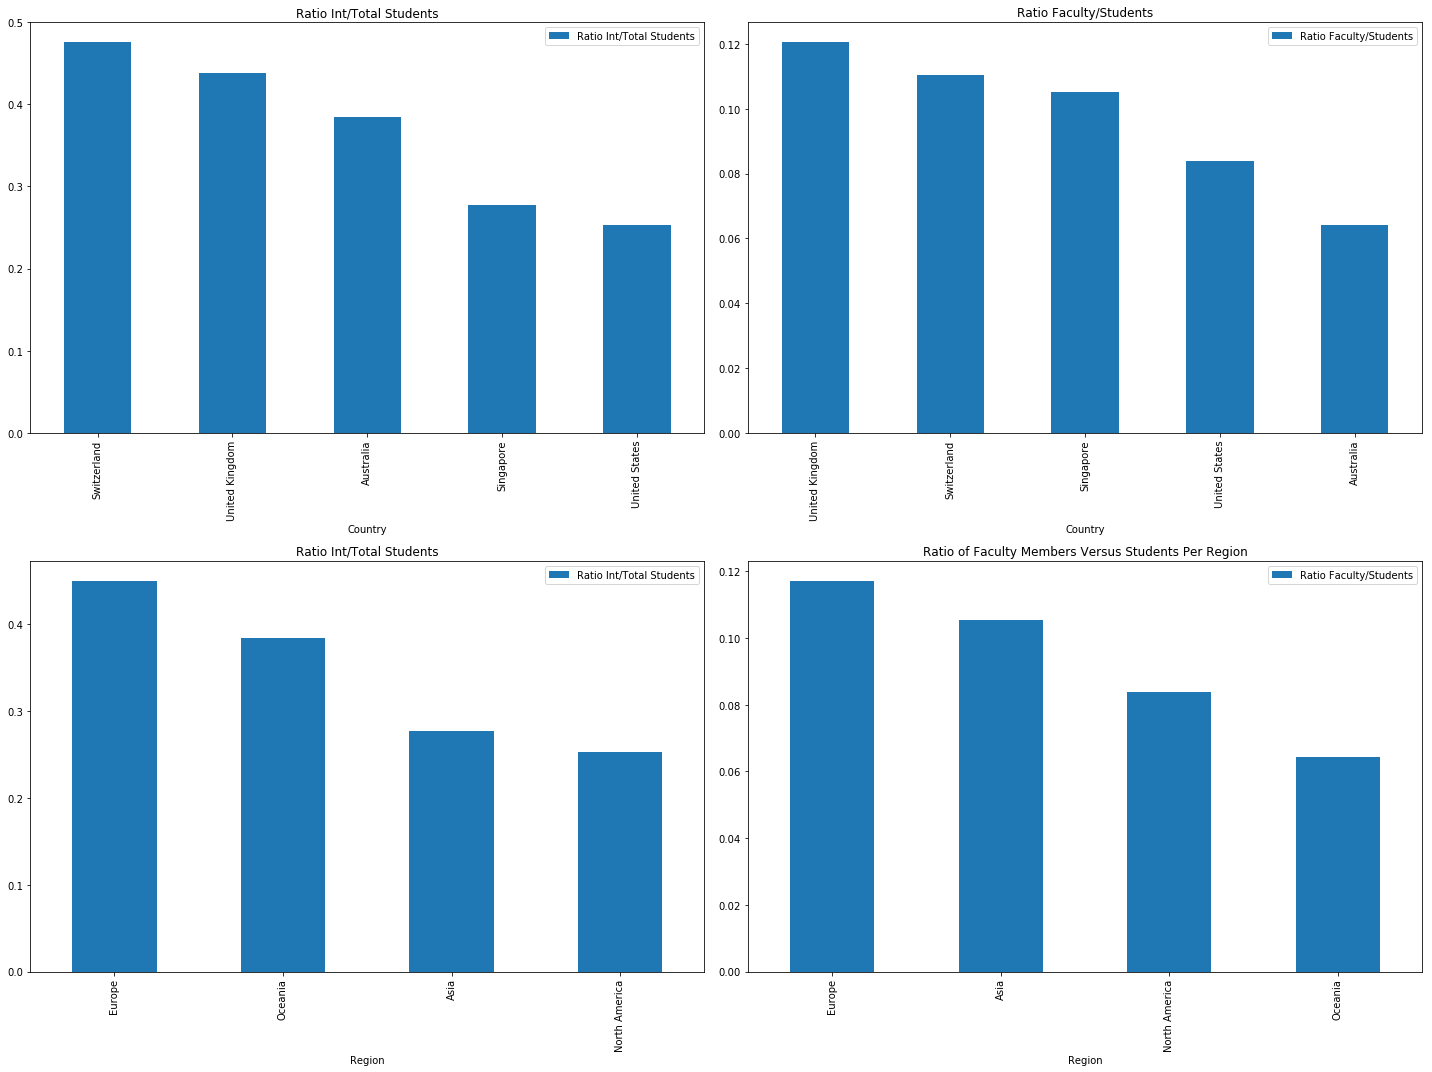

In [286]:
fig, axes = plt.subplots(nrows = 2, ncols =2, figsize  = (20,15))
country_rank_int_total_students.plot(kind = "bar", subplots = True, ax = axes[0,0])
plt.title("Ratio of International Students Per Country")
country_rank_fac_students.plot(kind = "bar", subplots = True, ax = axes[0,1])
plt.title("Ratio of Faculty Members Versus Students Per Country")
region_int_total_students.plot(kind = "bar", subplots = True, ax = axes[1,0])
plt.title("Ratio of International Students Per Region")
region_fac_students.plot(kind = "bar", subplots = True, ax = axes[1,1])
plt.title("Ratio of Faculty Members Versus Students Per Region")
fig.tight_layout()

# 2. Top University Ranking : THE
Next we Are going to load the data from the URL of THE. The main URL of the ranking page is the following : 

## 2.1. Mapping Countries to Regions 

Using the countries and regions columns, we can map each country to a specific region by converting the resulting dataframe to a dictionary

In [162]:
region_mapping = ranking_QS[['Country', 'Region']].set_index('Country').to_dict()['Region']
print(region_mapping)

{'United States': 'North America', 'United Kingdom': 'Europe', 'Switzerland': 'Europe', 'Singapore': 'Asia', 'Australia': 'Oceania'}


## 2.2. Recovering Data From The URLs

Using the same process as for the previous website, we will recover the desired information. Note that this website does not give any information regarding the regions which is where the mapping will come in handy. 

In [184]:
THE_base_URL = "www.timeshighereducation.com"
THE_data_URL = "https://www.timeshighereducation.com/sites/default/files/the_data_rankings/world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json"

In [185]:
THE_R = requests.get(THE_data_URL)
THE_dict = THE_R.json()['data']
THE_dict[0]

{'aliases': 'University of Oxford',
 'location': 'United Kingdom',
 'member_level': '0',
 'name': 'University of Oxford',
 'nid': 468,
 'rank': '1',
 'rank_order': '10',
 'record_type': 'master_account',
 'scores_citations': '99.1',
 'scores_citations_rank': '15',
 'scores_industry_income': '63.7',
 'scores_industry_income_rank': '169',
 'scores_international_outlook': '95.0',
 'scores_international_outlook_rank': '24',
 'scores_overall': '94.3',
 'scores_overall_rank': '10',
 'scores_research': '99.5',
 'scores_research_rank': '1',
 'scores_teaching': '86.7',
 'scores_teaching_rank': '5',
 'stats_female_male_ratio': '46 : 54',
 'stats_number_students': '20,409',
 'stats_pc_intl_students': '38%',
 'stats_student_staff_ratio': '11.2',
 'subjects_offered': 'Archaeology,Art, Performing Arts & Design,Biological Sciences,Business & Management,Chemical Engineering,Chemistry,Civil Engineering,Computer Science,Economics & Econometrics,Electrical & Electronic Engineering,General Engineering,Geo

Looking at the data recovered from the json file, we take the following :
- "rank" 
- "location" for the Country
- "name" for the university
- "stats_number_students" for the Number of students (total)
- "stats_pc_intl_students" $\times$ "stats_number_students" for the Number of students (int)
- "stats_number_students"$\div$"stats_student_staff_ratio" for the Number of faculty members (total) as the "stats_student_staff_ratio" represents the number of students per member of staff 
- we do not have any information regarding the number of international faculty members


In [186]:
ranking_THE = pd.DataFrame(columns = ['Name','Rank','Country','Region',\
                                     'Number of faculty members (int)','Number of faculty members (total)',\
                                     'Number of students (int)','Number of students (total)'])
ranking_THE.head()

,Name,Rank,Country,Region,Number of faculty members (int),Number of faculty members (total),Number of students (int),Number of students (total)


In [240]:
n_univ = len(ranking_QS)
for i in range(n_univ):
    univ_dict = THE_dict[i]
    # Directly extracting information
    rank = int(univ_dict['rank'].replace("=", ''))
    country = univ_dict['location']
    students_tot = int(univ_dict['stats_number_students'].replace(",", ""))
    name = univ_dict['name']
    # Computing international students
    percentage = int(univ_dict['stats_pc_intl_students'].replace("%", ""))/100
    students_int = np.round(int(univ_dict['stats_number_students'].replace(",", ""))*percentage)
    # Computing Faculty Members 
    faculty_tot = np.round(students_tot/float(univ_dict['stats_student_staff_ratio']))
    
    
    ranking_THE.loc[i] = [name, rank, country, region_mapping[country] ,\
                       np.nan, faculty_tot, students_int, students_tot]
    
ranking_THE[conv_2_int] = ranking_THE[conv_2_int].apply(pd.to_numeric)

In [241]:
ranking_THE.dtypes

Name                                  object
Rank                                   int64
Country                               object
Region                                object
Number of faculty members (int)      float64
Number of faculty members (total)    float64
Number of students (int)             float64
Number of students (total)             int64
dtype: object

In [242]:
ranking_THE['Number of students (int)'] = ranking_THE['Number of students (int)'].astype(int)
ranking_THE['Number of faculty members (total)'] = ranking_THE['Number of faculty members (total)'].astype(int)
ranking_THE.dtypes

Name                                  object
Rank                                   int64
Country                               object
Region                                object
Number of faculty members (int)      float64
Number of faculty members (total)      int64
Number of students (int)               int64
Number of students (total)             int64
dtype: object

## 2.3. Computing The Statistics

### (a)  Ratio between faculty members and students

In [297]:
ranking_THE['Ratio Faculty/Students'] = ranking_THE['Number of faculty members (total)']/ranking_THE['Number of students (total)']
ratio_fac_students = ranking_THE[['Name', 'Ratio Faculty/Students']].sort_values('Ratio Faculty/Students',ascending=False)
ratio_fac_students.set_index('Name', inplace = True)
ratio_fac_students.head(10)

,Ratio Faculty/Students
Name,
Yale University,0.232579
Johns Hopkins University,0.232546
Duke University,0.222208
Columbia University,0.163952
University of Chicago,0.161257
California Institute of Technology,0.153916
University of Pennsylvania,0.153823
Stanford University,0.133354
Princeton University,0.120427


### (b)  Ratio of international students

In [298]:
ranking_THE['Ratio Int/Total Students'] = ranking_THE['Number of students (int)']/ranking_THE['Number of students (total)']
ratio_int_students = ranking_QS[['Name', 'Ratio Int/Total Students']].sort_values('Ratio Int/Total Students',ascending=False)
ratio_int_students.set_index('Name', inplace = True)
ratio_int_students.head(10)

,Ratio Int/Total Students
Name,
Ecole Polytechnique Fédérale de Lausanne (EPFL),0.570047
Imperial College London,0.543567
UCL (University College London),0.477928
The Australian National University,0.384365
ETH Zurich - Swiss Federal Institute of Technology,0.381681
University of Oxford,0.372870
University of Cambridge,0.356899
Massachusetts Institute of Technology (MIT),0.335863
Columbia University,0.323617


### (c) By country : average ratio of international students and  ratio between faculty members and students
### TODO : ask if average by country or sorting by country

We are going to display the same statistic but for each country. We only consider the Top 10 countries here.

In [299]:
# Top 10 : ratio of international students by country
country_rank_int_total_students = ranking_THE.groupby('Country').mean().sort_values('Ratio Int/Total Students',ascending=False)\
            [['Ratio Int/Total Students']]
country_rank_int_total_students.head(10)

#https://stackoverflow.com/questions/27842613/pandas-groupby-sort-within-groups
#ranking_QS.groupby('Country').sort_values('Ratio Int/Total Students',ascending=False)\
#            [['Ratio Int/Total Students']].head(10)

,Ratio Int/Total Students
Country,
United Kingdom,0.442488
Switzerland,0.380024
United States,0.235320


In [300]:
# Top 10 : ratio between faculty members and students by country
country_rank_fac_students= ranking_THE.groupby('Country').mean().sort_values('Ratio Faculty/Students',ascending=False)\
            [['Ratio Faculty/Students']]
    
country_rank_fac_students.head(10)                                              

,Ratio Faculty/Students
Country,
United States,0.144142
United Kingdom,0.090993
Switzerland,0.068476


### (d) By region : average ratio of international students and  ratio between faculty members and students
### TODO : ask if average by region or sorting by region
We are going to display the same statistic but for each region. As we have 6 regions, we display the whole ranking.

In [301]:
# Ratio of international students by region
region_int_total_students = ranking_THE.groupby('Region').mean().sort_values('Ratio Int/Total Students',ascending=False)\
            [['Ratio Int/Total Students']]
region_students.head(10)

,Ratio Int/Total Students
Region,
Europe,0.450499
Oceania,0.384365
Asia,0.277091
North America,0.253303


In [302]:
# Ratio between faculty members and students by region
region_fac_students = ranking_QS.groupby('Region').mean().sort_values('Ratio Faculty/Students',ascending=False)\
            [['Ratio Faculty/Students']]

## 2.4. Bar Plots

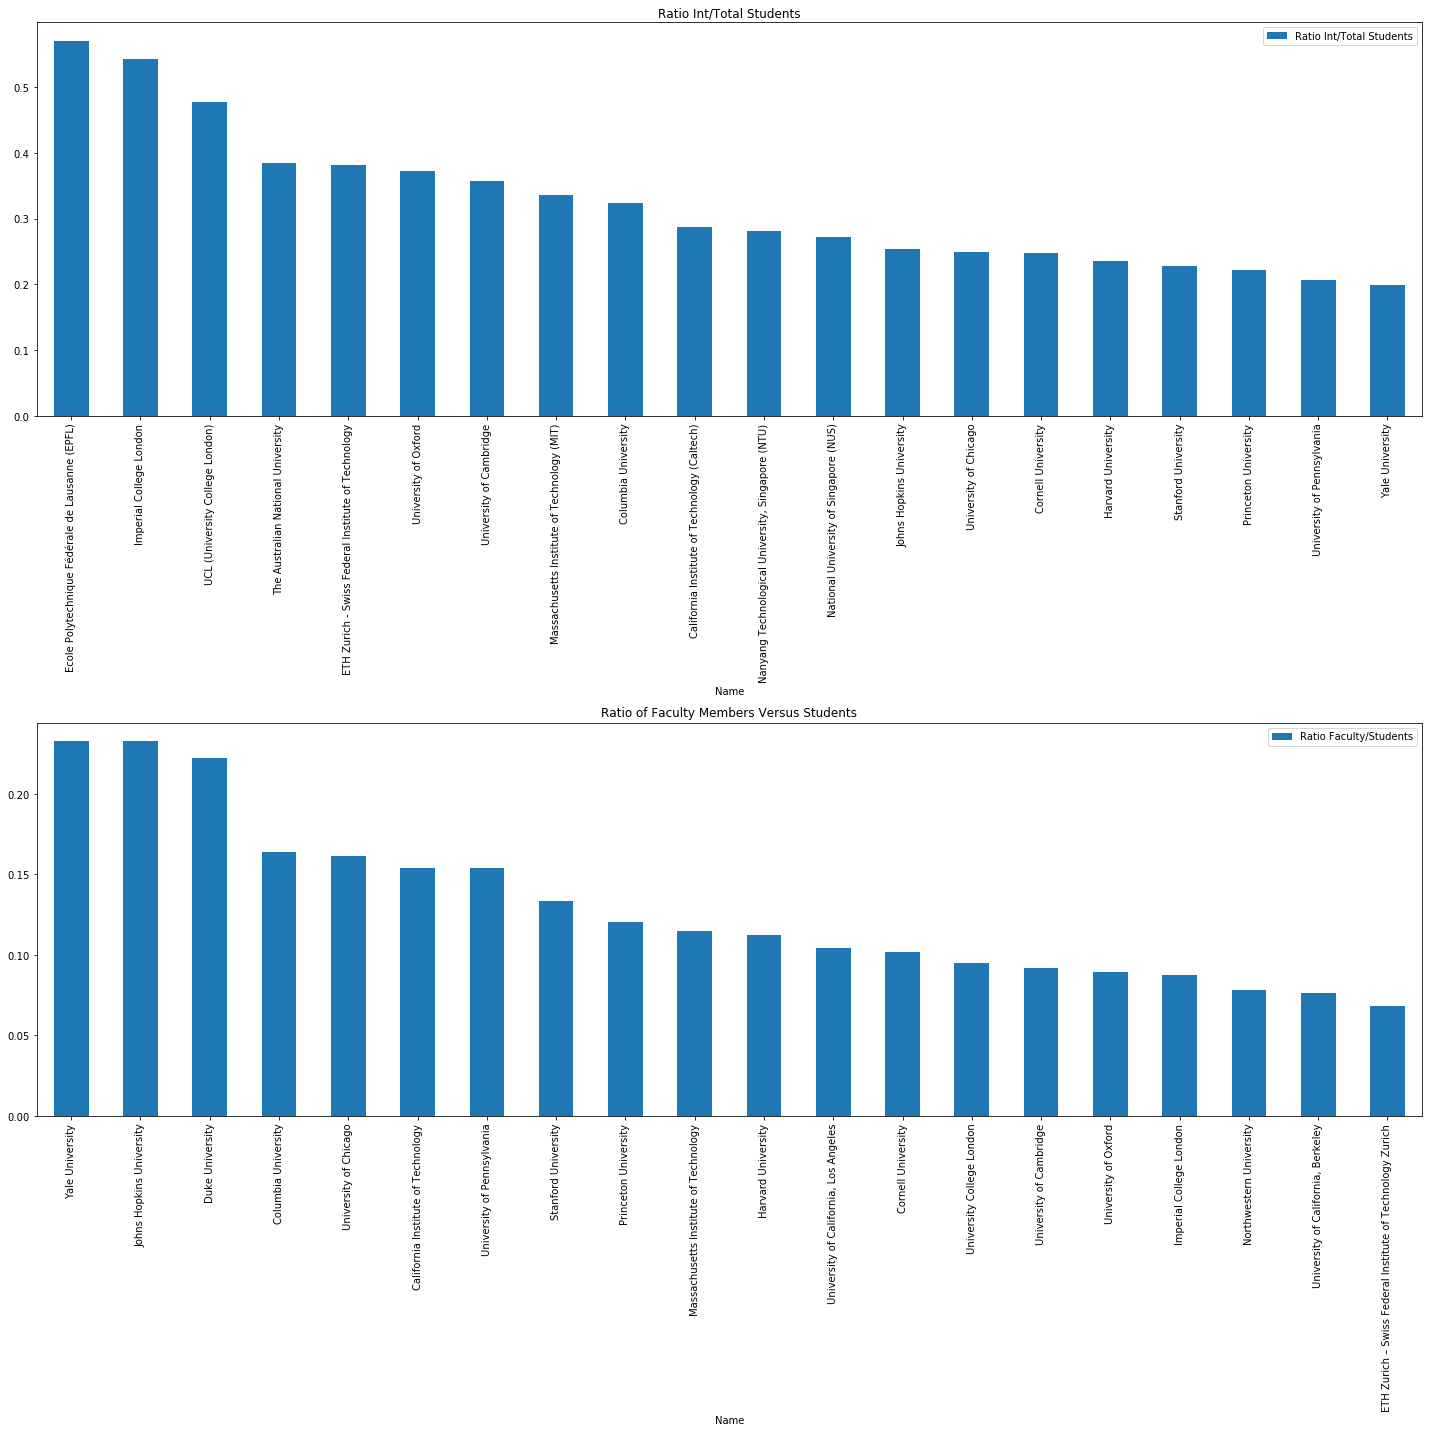

In [303]:
fig, axes = plt.subplots(nrows = 2, ncols =1, figsize  = (20,20))
ratio_int_students.plot(kind = "bar", subplots = True, ax = axes[0])
plt.title("Ratio of International Students")
ratio_fac_students.plot(kind = "bar", subplots = True, ax = axes[1])
plt.title("Ratio of Faculty Members Versus Students")
fig.tight_layout()

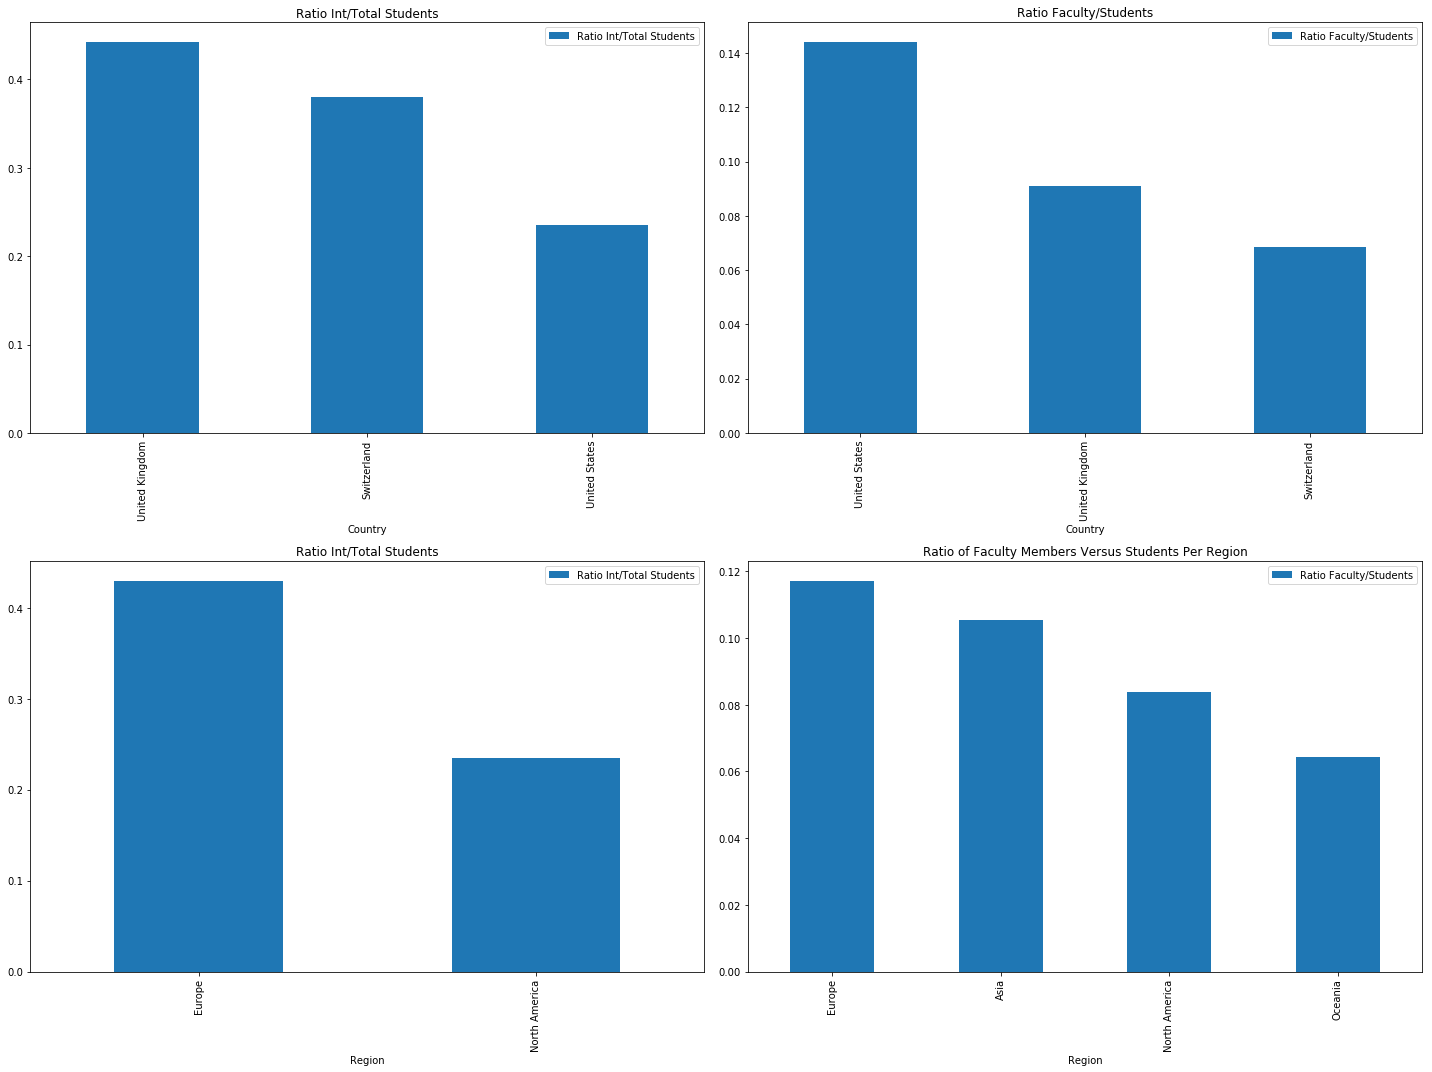

In [304]:
fig, axes = plt.subplots(nrows = 2, ncols =2, figsize  = (20,15))
country_rank_int_total_students.plot(kind = "bar", subplots = True, ax = axes[0,0])
plt.title("Ratio of International Students Per Country")
country_rank_fac_students.plot(kind = "bar", subplots = True, ax = axes[0,1])
plt.title("Ratio of Faculty Members Versus Students Per Country")
region_int_total_students.plot(kind = "bar", subplots = True, ax = axes[1,0])
plt.title("Ratio of International Students Per Region")
region_fac_students.plot(kind = "bar", subplots = True, ax = axes[1,1])
plt.title("Ratio of Faculty Members Versus Students Per Region")
fig.tight_layout()

# 3. Merging the DataFrames

In [307]:
ranking_THE

,Name,Rank,Country,Region,Number of faculty members (int),Number of faculty members (total),Number of students (int),Number of students (total),Ratio Faculty/Students,Ratio Int/Total Students
0,University of Oxford,1,United Kingdom,Europe,NaN,1822,7755,20409,0.089274,0.379979
1,University of Cambridge,2,United Kingdom,Europe,NaN,1687,6436,18389,0.091740,0.349992
2,California Institute of Technology,3,United States,North America,NaN,340,596,2209,0.153916,0.269805
3,Stanford University,3,United States,North America,NaN,2113,3486,15845,0.133354,0.220006
4,Massachusetts Institute of Technology,5,United States,North America,NaN,1285,3800,11177,0.114968,0.339984
5,Harvard University,6,United States,North America,NaN,2284,5285,20326,0.112368,0.260012
6,Princeton University,7,United States,North America,NaN,958,1909,7955,0.120427,0.239975
7,Imperial College London,8,United Kingdom,Europe,NaN,1391,8721,15857,0.087722,0.549978
8,University of Chicago,9,United States,North America,NaN,2181,3381,13525,0.161257,0.249982
9,ETH Zurich – Swiss Federal Institute of Techno...,10,Switzerland,Europe,NaN,1317,7309,19233,0.068476,0.380024


In [310]:
ranking_QS.sort_values('Rank',ascending=True)

,Name,Rank,Country,Region,Number of faculty members (int),Number of faculty members (total),Number of students (int),Number of students (total),Ratio Faculty/Students,Ratio Int/Total Students
0,Massachusetts Institute of Technology (MIT),1,United States,North America,2982,1679,3717,11067,0.151712,0.335863
1,Stanford University,2,United States,North America,4285,2042,3611,15878,0.128606,0.227422
2,Harvard University,3,United States,North America,4350,1311,5266,22429,0.058451,0.234785
3,California Institute of Technology (Caltech),4,United States,North America,953,350,647,2255,0.155211,0.286918
4,University of Cambridge,5,United Kingdom,Europe,5490,2278,6699,18770,0.121364,0.356899
5,University of Oxford,6,United Kingdom,Europe,6750,2964,7353,19720,0.150304,0.372870
6,UCL (University College London),7,United Kingdom,Europe,6345,2554,14854,31080,0.082175,0.477928
7,Imperial College London,8,United Kingdom,Europe,3930,2071,8746,16090,0.128713,0.543567
8,University of Chicago,9,United States,North America,2449,635,3379,13557,0.046839,0.249244
9,ETH Zurich - Swiss Federal Institute of Techno...,10,Switzerland,Europe,2477,1886,7563,19815,0.095180,0.381681
